In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Fetch data

In [2]:
## Definitions to access and download files by name from the Copernicus Dataspace

import requests
import pandas as pd
import subprocess
import os
import time
import shutil
import json
from datetime import date
from joblib import Parallel, delayed
import zipfile
import sys
import glob
import numpy as np

def get_access_token(username, password):
    """
    Obtain an access token to the Copernicus Data Space Ecosystem.
    Necessary for the download of hosted products.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
            --header 'Content-Type: application/x-www-form-urlencoded' \
            --data-urlencode 'grant_type=password' \
            --data-urlencode 'username={username}' \
            --data-urlencode 'password={password}' \
            --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_new_access_token(refresh_token):
    """
    Obtain a new access token to the Copernicus Data Space Ecosystem using a previously provided refesh token.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
    --header 'Content-Type: application/x-www-form-urlencoded' \
    --data-urlencode 'grant_type=refresh_token' \
    --data-urlencode 'refresh_token={refresh_token}' \
    --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_S1_products_by_names(names):
    """
    Obtain a pandas dataframe of Sentinel products for a given list of product names.
    """
    all_results = []

    base_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="

    for name in names:
        query_url = f"{base_url}Name eq '{name}'&$top=1000"

        response = requests.get(query_url)
        json_response = response.json()

        if 'value' in json_response:
            all_results.extend(json_response['value'])

    results_df = pd.DataFrame.from_dict(all_results)

    if not results_df.empty:
        results_df['Satellite'] = [row['Name'][:3] for i, row in results_df.iterrows()]
        results_df['SensingStart'] = [pd.to_datetime(row['ContentDate']['Start']) for i, row in results_df.iterrows()]
        results_df['SensingEnd'] = [pd.to_datetime(row['ContentDate']['End']) for i, row in results_df.iterrows()]
        results_df = results_df.sort_values(by='SensingStart')

    return results_df

def download_single_product(product_id, file_name, access_token, download_dir="downloaded_products"):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

In [3]:
cop_dspace_usrnm = 'zcfbcmo@ucl.ac.uk' # copernicus dataspace username
cop_dspace_psswrd = 'TheStudy2018!'# copernicus dataspace password
token, refresh_token = get_access_token(cop_dspace_usrnm, cop_dspace_psswrd)
product_names = [
    "S1A_EW_GRDM_1SDH_20230419T121123_20230419T121223_048165_05CA73_A681.SAFE", # Pond Inlet Sentinel-1 swath
    "S1A_EW_GRDM_1SDH_20230419T135049_20230419T135145_048166_05CA7C_5C05.SAFE", # Cambridge Bay
    "S1A_EW_GRDM_1SDH_20230420T125214_20230420T125314_048180_05CAF1_BDD4.SAFE"  # Arctic Bay
]

results_df = get_S1_products_by_names(product_names)
print(results_df)

    @odata.mediaContentType                                    Id  \
0  application/octet-stream  3e9b5f91-0b2e-4886-aa70-9e94cad1b3d3   
1  application/octet-stream  176fb6bf-1a72-41a2-a092-dc17f29cd6da   
2  application/octet-stream  cb70c5b0-8c72-4930-8603-cd7a38f222ad   

                                                Name  \
0  S1A_EW_GRDM_1SDH_20230419T121123_20230419T1212...   
1  S1A_EW_GRDM_1SDH_20230419T135049_20230419T1351...   
2  S1A_EW_GRDM_1SDH_20230420T125214_20230420T1253...   

                ContentType  ContentLength                OriginDate  \
0  application/octet-stream      432493812  2023-04-19T14:02:20.522Z   
1  application/octet-stream      393093760  2023-04-19T16:23:50.682Z   
2  application/octet-stream      425976719  2023-04-20T14:54:50.396Z   

            PublicationDate          ModificationDate  Online EvictionDate  \
0  2023-04-19T14:15:32.923Z  2024-03-07T08:53:48.767Z    True                
1  2023-04-19T16:30:31.287Z  2024-03-07T08:52:51.306Z

In [ ]:
## Assuming download_single_product is a function taking product_id, file_name, token, and download_dir as arguments

download_dir = '/content/drive/MyDrive/GEOL0069/project'

# Loop through each row in the DataFrame
for index, row in results_df.iterrows():
    product_id = row['Id']
    file_name = row['Name']

    # Call the download function for each product
    download_single_product(product_id, file_name, token, download_dir)

Downloaded: /content/drive/MyDrive/GEOL0069/project/S1A_EW_GRDM_1SDH_20230419T121123_20230419T121223_048165_05CA73_A681.SAFE.zip
Downloaded: /content/drive/MyDrive/GEOL0069/project/S1A_EW_GRDM_1SDH_20230419T135049_20230419T135145_048166_05CA7C_5C05.SAFE.zip
Downloaded: /content/drive/MyDrive/GEOL0069/project/S1A_EW_GRDM_1SDH_20230420T125214_20230420T125314_048180_05CAF1_BDD4.SAFE.zip


In [ ]:
########################################################################################################################
## Details on pre-processing steps applied to downloaded Sentinel-1 data can be found in the GitHub (GEOL0069_Project)##
########################################################################################################################

In [4]:
!pip install GDAL numpy

In [5]:
## Define function to extract lon (X), lat (Y) and pixel values (Z) from .tif files and export as .npy

import numpy as np
from osgeo import gdal

def export_xyz_to_npy(tif_path, x_output_path, y_output_path, z_output_path):
    dataset = gdal.Open(tif_path)
    if not dataset:
        raise FileNotFoundError("TIFF file not found or unable to open.")

    # Get raster band
    band = dataset.GetRasterBand(1)
    raster = band.ReadAsArray()
    transform = dataset.GetGeoTransform()

    # Calculate X and Y coordinates for each pixel
    x_pixels = raster.shape[1]  # Number of columns
    y_pixels = raster.shape[0]  # Number of rows
    (x_origin, pixel_width, _, y_origin, _, pixel_height) = transform  # Unpacking geotransform

    # Generate coordinate arrays for X and Y
    x_coords = x_origin + np.arange(x_pixels) * pixel_width
    y_coords = y_origin + np.arange(y_pixels) * pixel_height

    # Create meshgrids of X and Y coordinates
    x_grid, y_grid = np.meshgrid(x_coords, y_coords, indexing='xy')

    # Save X, Y, and Z (pixel values) arrays to separate .npy files
    np.save(x_output_path, x_grid)
    np.save(y_output_path, y_grid)
    np.save(z_output_path, raster)

    print(f"X (longitude) coordinates saved to {x_output_path}")
    print(f"Y (latitude) coordinates saved to {y_output_path}")
    print(f"Z (pixel brightness) values saved to {z_output_path}")

In [ ]:
## Pond Inlet pre-processed Sentinel-1 .tif files to .npy

# tif_path = '/content/drive/MyDrive/GEOL0069/project/tif_files/subset_HH_pro_2023_17N.tif'
# tif_path = '/content/drive/MyDrive/GEOL0069/project/tif_files/subset_HH_pro_2023_18N.tif'

x_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lon_S1_17N.npy'
y_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lat_S1_17N.npy'
z_output_path = '/content/drive/MyDrive/GEOL0069/project/data/HH_S1_17N.npy'
export_xyz_to_npy(tif_path, x_output_path, y_output_path, z_output_path)

X (longitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/data/lon_S1_17N.npy
Y (latitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/data/lat_S1_17N.npy
Z (pixel brightness) values saved to /content/drive/MyDrive/GEOL0069/project/data/HH_S1_17N.npy


In [ ]:
## Pond Inlet photogrammetry derived DEM .tif files to .npy

tif_path = '/content/drive/MyDrive/GEOL0069/project/tif_files/2023-04-22_s6grid300_dsm_wav_dem_a10_z10_clip.tif'
x_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lon_DEM_s6.npy'
y_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lat_DEM_s6.npy'
z_output_path = '/content/drive/MyDrive/GEOL0069/project/data/z_DEM_s6.npy'
export_xyz_to_npy(tif_path, x_output_path, y_output_path, z_output_path)

X (longitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/lon_DEM_s6.npy
Y (latitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/lat_DEM_s6.npy
Z (pixel brightness) values saved to /content/drive/MyDrive/GEOL0069/project/HH_DEM_s6.npy


### Colocate data and testing different roughness metrics

In [6]:
## Load Sentinel-1 and DEM .npy files for lon, lat and pixel values, brightness for Sentinel-1 and elevation for DEMs

import numpy as np
path = '/content/drive/MyDrive/GEOL0069/project/data/' # You need to specify the path

# note for coordinate systems: s2, 3 and 7 DEM grids = 18N (ESPG:32618); s1, 5 and 6 DEM grids = 17N (EPSG:32617)

lon_S1=np.load(path+'lon_S1_17N.npy')
lat_S1=np.load(path+'lat_S1_17N.npy')
brightness=np.load(path+'HH_S1_17N.npy')

lon_DEM=np.load(path+'lon_DEM_s1.npy')
lat_DEM=np.load(path+'lat_DEM_s1.npy')
elevation=np.load(path+'z_DEM_s1.npy')

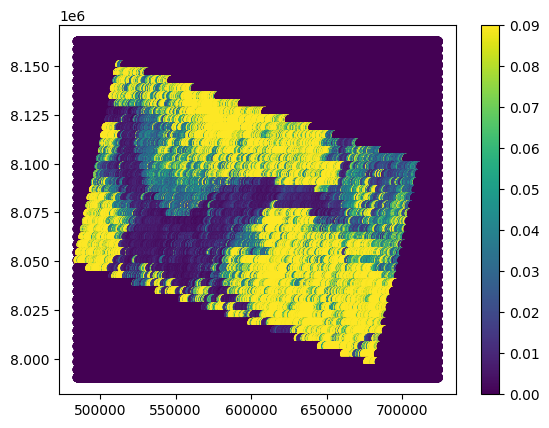

In [7]:
## Quick visualisation of loaded Sentinel-1 data
import matplotlib.pyplot as plt

plt.scatter(lon_S1[::100],lat_S1[::100],c=brightness[::100],vmin=0,vmax=0.09)
plt.colorbar()
plt.show()

In [8]:
print(np.min(elevation),np.max(elevation)) # note -9999 is the value used to replace no data

-9999.0 2.402226


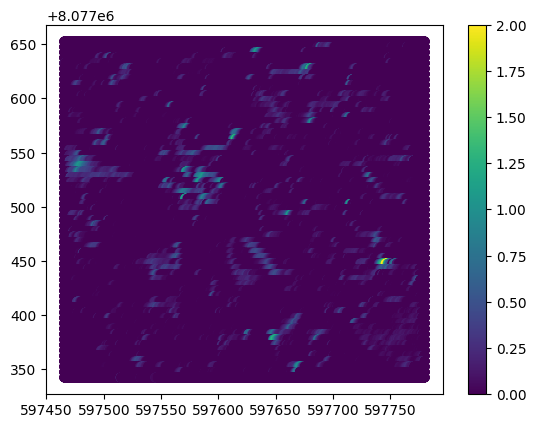

In [9]:
## Quick visualisation of loaded DEM data
import matplotlib.pyplot as plt

plt.scatter(lon_DEM[::100],lat_DEM[::100],c=elevation[::100],vmin=0,vmax=2)
plt.colorbar()
plt.show()

In [10]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.3 MB/s eta 0:00:00


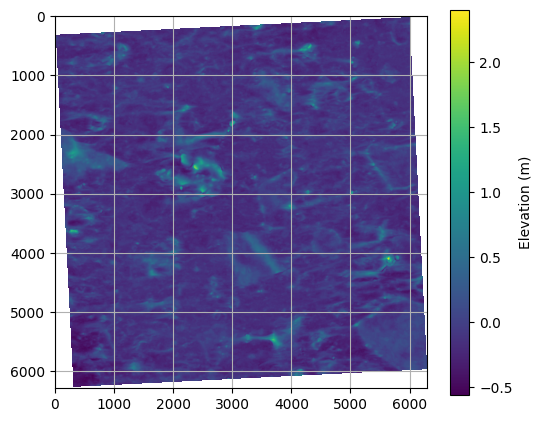

In [11]:
## Visualise DEM .tif file, removing no data values

import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = '/content/drive/MyDrive/GEOL0069/project/tif_files/'

# dem_dataset_path = tif_path+'2023-04-18_s7grid300_dsm_wav_dem_a10_z10_clip.tif'
dem_dataset_path = tif_path+'2023-04-19_s1grid300_dsm_wav_dem_a10_z10_clip.tif'
# dem_dataset_path = tif_path+'2023-04-20_s3grid300_dsm_wav_dem_a10_z10_clip.tif'
# dem_dataset_path = tif_path+'2023-04-21_s2grid300_dsm_wav_dem_a10_z10_clip.tif'
# dem_dataset_path = tif_path+'2023-04-22_s5grid300_dsm_wav_dem_a10_z10_clip.tif'
# dem_dataset_path = tif_path+'2023-04-22_s6grid300_dsm_wav_dem_a10_z10_clip.tif'

dem_dataset = rasterio.open(dem_dataset_path)
dem_data = dem_dataset.read(1)

# Mask out no data values
nodata_value = dem_dataset.nodata
dem_data[dem_data == nodata_value] = np.nan

plt.figure(figsize=(6, 5))
plt.imshow(dem_data, cmap='viridis', vmin=np.nanmin(dem_data), vmax=np.nanmax(dem_data))
plt.colorbar(label='Elevation (m)')
plt.grid(True)

plt.show()

In [12]:
## Flatten array to collapse into 1-D vector

lon_DEM_flat = lon_DEM.flatten()
lat_DEM_flat = lat_DEM.flatten()
elevation_flat = elevation.flatten()

lon_S1_flat = lon_S1.flatten()
lat_S1_flat = lat_S1.flatten()
brightness_flat = brightness.flatten()

print(lon_DEM.shape,lon_DEM_flat)

(6292, 6292) [597465.45 597465.5  597465.55 ... 597779.9  597779.95 597780.  ]


In [13]:
## Replace -9999 to no data before calculating RMS

DEM_MISSING_DATA_VALUE = -9999
elevation_flat[elevation_flat == DEM_MISSING_DATA_VALUE] = np.nan

In [14]:
## Calculate RMS by binning longitude and latitude into grid cells and save as .npy format

# Define the size of the grid cells
grid_size = 20  # metres
# grid_size = 40  # metres

# Define bins for lon/lat
lon_bins = np.arange(min(lon_DEM_flat), max(lon_DEM_flat) + grid_size, grid_size)
lat_bins = np.arange(min(lat_DEM_flat), max(lat_DEM_flat) + grid_size, grid_size)

# Arrays to store RMS values and centre coordinates of bins
rms_values = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
lon_centers = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
lat_centers = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# Calculate RMS for each grid cell
for i in range(len(lon_bins) - 1):
    for j in range(len(lat_bins) - 1):
        # Indices of points within each bin
        indices = np.where((lon_DEM_flat >= lon_bins[i]) & (lon_DEM_flat < lon_bins[i+1]) &
                           (lat_DEM_flat >= lat_bins[j]) & (lat_DEM_flat < lat_bins[j+1]))
        elevations = elevation_flat[indices]
        if elevations.size > 0:
            rms_values[j, i] = np.sqrt(np.mean(np.square(elevations)))
        # Calculate centre coordinates of each bin
        lon_centers[j, i] = (lon_bins[i] + lon_bins[i + 1]) / 2
        lat_centers[j, i] = (lat_bins[j] + lat_bins[j + 1]) / 2

# Flatten the arrays
lon_centers_flat = lon_centers.flatten()
lat_centers_flat = lat_centers.flatten()
rms_values_flat = rms_values.flatten()

In [15]:
## Change variable names

lon_RMS_flat = lon_centers_flat
lat_RMS_flat = lat_centers_flat
RMS_flat = rms_values_flat

In [ ]:
# ## Calculate range by binning longitude and latitude into grid cells and save as .npy format

# # Define the size of the grid cells
# grid_size = 40  # meters

# # Define bins for lon/lat
# lon_bins = np.arange(min(lon_DEM_flat), max(lon_DEM_flat) + grid_size, grid_size)
# lat_bins = np.arange(min(lat_DEM_flat), max(lat_DEM_flat) + grid_size, grid_size)

# # Arrays to store range values and centre coordinates of bins
# range_values = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
# lon_centers = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
# lat_centers = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# # Calculate range for each grid cell
# for i in range(len(lon_bins) - 1):
#     for j in range(len(lat_bins) - 1):
#         # Indices of points within each bin
#         indices = np.where((lon_DEM_flat >= lon_bins[i]) & (lon_DEM_flat < lon_bins[i+1]) &
#                            (lat_DEM_flat >= lat_bins[j]) & (lat_DEM_flat < lat_bins[j+1]))
#         elevations = elevation_flat[indices]
#         if elevations.size > 0:
#             elevation_range = np.max(elevations) - np.min(elevations)
#             range_values[j, i] = elevation_range
#         # Calculate centre coordinates of each bin
#         lon_centers[j, i] = (lon_bins[i] + lon_bins[i + 1]) / 2
#         lat_centers[j, i] = (lat_bins[j] + lat_bins[j + 1]) / 2

# # Flatten the arrays
# lon_centers_flat = lon_centers.flatten()
# lat_centers_flat = lat_centers.flatten()
# range_values_flat = range_values.flatten()

In [ ]:
# ## Change variable names

# lon_range_flat = lon_centers_flat
# lat_range_flat = lat_centers_flat
# range_flat = range_values_flat

In [ ]:
# ## Calculate standard deviation by binning longitude and latitude into grid cells and save as .npy format

# # Define the size of the grid cells
# grid_size = 40  # meters

# # Define bins for lon/lat
# lon_bins = np.arange(min(lon_DEM_flat), max(lon_DEM_flat) + grid_size, grid_size)
# lat_bins = np.arange(min(lat_DEM_flat), max(lat_DEM_flat) + grid_size, grid_size)

# # Arrays to store range values and centre coordinates of bins
# std_dev_values = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
# lon_centers = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
# lat_centers = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

# # Calculate range for each grid cell
# for i in range(len(lon_bins) - 1):
#     for j in range(len(lat_bins) - 1):
#         # Indices of points within each bin
#         indices = np.where((lon_DEM_flat >= lon_bins[i]) & (lon_DEM_flat < lon_bins[i+1]) &
#                            (lat_DEM_flat >= lat_bins[j]) & (lat_DEM_flat < lat_bins[j+1]))
#         elevations = elevation_flat[indices]
#         if elevations.size > 0:
#             elevation_std_dev = np.std(elevations)
#             std_dev_values[j, i] = elevation_std_dev
#         # Calculate centre coordinates of each bin
#         lon_centers[j, i] = (lon_bins[i] + lon_bins[i + 1]) / 2
#         lat_centers[j, i] = (lat_bins[j] + lat_bins[j + 1]) / 2

# # Flatten the arrays
# lon_centers_flat = lon_centers.flatten()
# lat_centers_flat = lat_centers.flatten()
# std_dev_values_flat = std_dev_values.flatten()

In [ ]:
# ## Change variable names

# lon_std_flat = lon_centers_flat
# lat_std_flat = lat_centers_flat
# std_flat = std_dev_values_flat

In [16]:
## Introduce cKDTree and create KD-tree with Sentinel-1 data

from scipy.spatial import cKDTree

# Combine lon and lat into a single array
points_S1 = np.column_stack((lon_S1_flat, lat_S1_flat))

# Create the KD-tree
tree_S1 = cKDTree(points_S1)

In [17]:
## Query Sentinel-1 tree with RMS values

# Combine lon and lat into a single array
points_RMS = np.column_stack((lon_RMS_flat, lat_RMS_flat))

# Query the KD-tree: find the nearest point in S1 for each point in RMS
distances, indices = tree_S1.query(points_RMS)

In [ ]:
# ## Query Sentinel-1 tree with range values

# # Combine lon and lat into a single array
# points_range = np.column_stack((lon_range_flat, lat_range_flat))

# # Query the KD-tree: find the nearest point in S1 for each point in range
# distances, indices = tree_S1.query(points_range)

In [ ]:
# ## Query Sentinel-1 tree with std dev values

# # Combine lon and lat into a single array
# points_std = np.column_stack((lon_std_flat, lat_std_flat))

# # Query the KD-tree: find the nearest point in S1 for each point in std
# distances, indices = tree_S1.query(points_std)

In [18]:
print(indices)

[12702716 12702717 12702717 12702718 12702718 12702719 12702719 12702720
 12702720 12702721 12702721 12702722 12702722 12702723 12702723 12702724
 12702716 12702717 12702717 12702718 12702718 12702719 12702719 12702720
 12702720 12702721 12702721 12702722 12702722 12702723 12702723 12702724
 12696748 12696749 12696749 12696750 12696750 12696751 12696751 12696752
 12696752 12696753 12696753 12696754 12696754 12696755 12696755 12696756
 12696748 12696749 12696749 12696750 12696750 12696751 12696751 12696752
 12696752 12696753 12696753 12696754 12696754 12696755 12696755 12696756
 12690780 12690781 12690781 12690782 12690782 12690783 12690783 12690784
 12690784 12690785 12690785 12690786 12690786 12690787 12690787 12690788
 12690780 12690781 12690781 12690782 12690782 12690783 12690783 12690784
 12690784 12690785 12690785 12690786 12690786 12690787 12690787 12690788
 12684812 12684813 12684813 12684814 12684814 12684815 12684815 12684816
 12684816 12684817 12684817 12684818 12684818 12684

In [19]:
## Use indices from querying S1 tree with the chosen DEM roughness metric to index matched S1 points

matched_points_S1 = points_S1[indices]
lon_matched_points_S1 = matched_points_S1[:,0]
lat_matched_points_S1 = matched_points_S1[:,1]

brightness_matched_points = brightness_flat[indices]

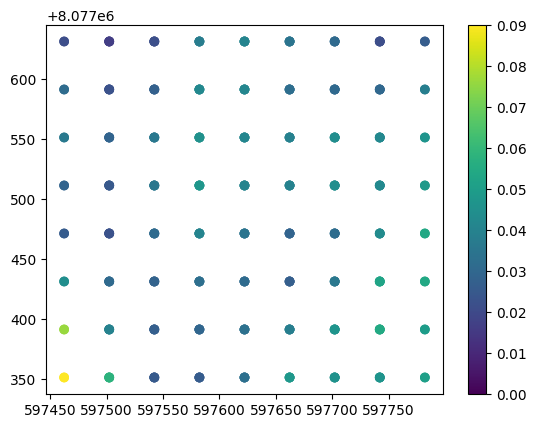

In [20]:
## Plot matched S1 points

import matplotlib.pyplot as plt
plt.scatter(lon_matched_points_S1,lat_matched_points_S1,c=brightness_matched_points, vmin=0,vmax=0.09)
plt.colorbar()

In [21]:
brightness_matched_points.shape

(256,)

In [22]:
## Convert linear units to dB

# Set a minimum threshold to avoid log of zero
brightness_matched_points[brightness_matched_points <= 0] = 1e-10

db_brightness = 10 * np.log10(brightness_matched_points)

In [23]:
## Convert metres to ft for RMS
RMS_ft = RMS_flat*3.28084

In [ ]:
## Convert metres to ft for range
# range_ft = range_flat*3.28084

In [ ]:
## Convert metres to ft for standard deviation
# std_ft = std_flat*3.28084

In [ ]:
## Save matched brightness and roughness metric points for RMS
# np.save(path+'20_db_DEM_s1.npy', db_brightness)
# np.save(path+'20_RMS_DEM_s1.npy', RMS_ft)

In [24]:
## Load matched brightness and roughness metric points for RMS
db_brightness = np.load(path+'20_db_DEM_s1.npy')
RMS_ft = np.load(path+'20_RMS_DEM_s1.npy')

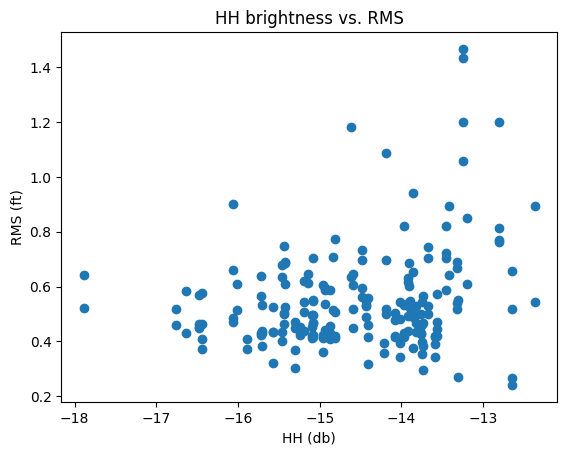

In [25]:
## Scatter plot of matched brightness and roughness metric points for individual DEM grids

plt.scatter(db_brightness, RMS_ft)
plt.title('HH brightness vs. RMS')
plt.xlabel('HH (db)')
plt.ylabel('RMS (ft)')

# plt.savefig('/content/drive/MyDrive/GEOL0069/project/S1_17N_s1_DEM.png',dpi=400)
plt.show()

In [ ]:
## Save matched brightness and roughness metric points for range
# np.save(path+'db_range_DEM_s7.npy', db_brightness)
# np.save(path+'range_DEM_s7.npy', range_ft)

In [ ]:
# ## Scatter plot of matched brightness and roughness metric points for individual DEM grids

# plt.scatter(db_brightness, range_ft)
# plt.title('HH brightness vs. Range')
# plt.xlabel('HH (db)')
# plt.ylabel('Range (ft)')

# plt.show()

In [ ]:
## Save matched brightness and roughness metric points for standard deviation
# np.save(path+'db_std_DEM_s6.npy', db_brightness)
# np.save(path+'std_DEM_s6.npy', std_ft)

In [ ]:
# ## Scatter plot of matched brightness and roughness metric points for individual DEM grids
# plt.scatter(db_brightness, std_ft)
# plt.title('HH brightness vs. Std Dev')
# plt.xlabel('HH (db)')
# plt.ylabel('Std Dev (ft)')

# plt.show()

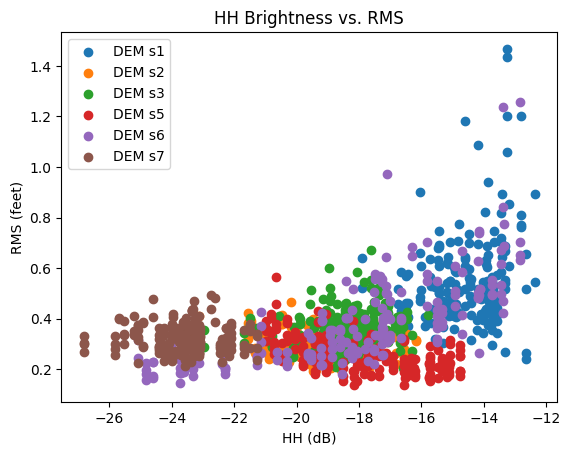

In [26]:
## Plot all the brightness and roughness datasets in same figure, for RMS

file_numbers = [1,2,3,5,6,7]
combined_db = np.array([])
combined_rms = np.array([])

for i in file_numbers:
    # Path to individual DEM data
    db_file = path + f'20_db_DEM_s{i}.npy'
    rms_file = path + f'20_RMS_DEM_s{i}.npy'

    # Load data from files
    db_brightness = np.load(db_file)
    RMS_ft = np.load(rms_file)

    # Scatter plot of the loaded data
    plt.scatter(db_brightness, RMS_ft, label=f'DEM s{i}')

plt.xlabel('HH (dB)')
plt.ylabel('RMS (feet)')
plt.legend()
plt.title('HH Brightness vs. RMS')

plt.show()

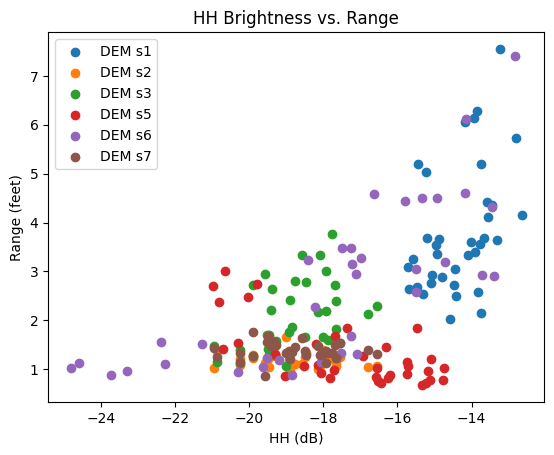

In [27]:
## Plot all the brightness and roughness datasets in same figure, for range

file_numbers = [1,2,3,5,6,7]

for i in file_numbers:
    # Path to individual DEM data
    db_file = path + f'db_range_DEM_s{i}.npy'
    rms_file = path + f'range_DEM_s{i}.npy'

    # Load data from files
    db_brightness = np.load(db_file)
    RMS_ft = np.load(rms_file)

    # Scatter plot of the loaded data
    plt.scatter(db_brightness, RMS_ft, label=f'DEM s{i}')

plt.xlabel('HH (dB)')
plt.ylabel('Range (feet)')
plt.legend()
plt.title('HH Brightness vs. Range')

plt.show()

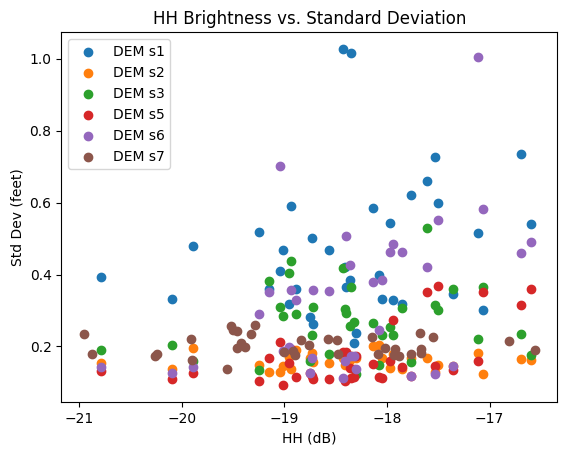

In [28]:
## Plot all the brightness and roughness datasets in same figure, for standard deviation

file_numbers = [1,2,3,5,6,7]

for i in file_numbers:
    # Path to individual DEM data
    db_file = path + f'db_std_DEM_s{i}.npy'
    rms_file = path + f'std_DEM_s{i}.npy'

    # Load data from files
    db_brightness = np.load(db_file)
    RMS_ft = np.load(rms_file)

    # Scatter plot of the loaded data
    plt.scatter(db_brightness, RMS_ft, label=f'DEM s{i}')

plt.xlabel('HH (dB)')
plt.ylabel('Std Dev (feet)')
plt.legend()
plt.title('HH Brightness vs. Standard Deviation')

plt.show()

In [ ]:
# ## Combine brightness and roughness metric points for all DEMs into arrays, save as .npy

# file_numbers = [1,2,3,5,6,7]
# combined_db = np.array([])
# combined_rms = np.array([])

# for i in file_numbers:
#     # Create file names based on the current number in the loop
#     db_file = path + f'20_db_DEM_s{i}.npy'
#     rms_file = path + f'20_RMS_DEM_s{i}.npy'

#     # Load data from files
#     db_brightness = np.load(db_file)
#     RMS_ft = np.load(rms_file)

#     # Append data to the combined arrays
#     combined_db = np.concatenate((combined_db, db_brightness))
#     combined_rms = np.concatenate((combined_rms, RMS_ft))

# np.save(path + '20_combined_db_DEM.npy', combined_db) # 20 for grid cell size (20 metres)
# np.save(path + '20_combined_rms_DEM.npy', combined_rms)

In [29]:
## Compare size of individual DEM dataset and combined

db_brightness = np.load(path+'20_db_DEM_s1.npy')
RMS_ft = np.load(path+'20_RMS_DEM_s1.npy')

combined_db = np.load(path+'20_combined_db_DEM.npy')
combined_rms = np.load(path+'20_combined_rms_DEM.npy')

print(db_brightness.shape,RMS_ft.shape,combined_db.shape,combined_rms.shape)

(256,) (256,) (1536,) (1536,)


In [ ]:
# ## Combine brightness and roughness metric points for all DEMs into (256,6) array instead of flat, save as .npy

# import numpy as np

# file_numbers = [1, 2, 3, 5, 6, 7]
# combined_db = []
# combined_rms = []

# for i in file_numbers:
#     # Create file names based on the current number in the loop
#     db_file = path + f'20_db_DEM_s{i}.npy'
#     rms_file = path + f'20_RMS_DEM_s{i}.npy'

#     # Load data from files
#     db_brightness = np.load(db_file)
#     RMS_ft = np.load(rms_file)

#     # Append data to the combined lists
#     combined_db.append(db_brightness)
#     combined_rms.append(RMS_ft)

# # Concatenate the lists into flat arrays
# combined_db = np.concatenate(combined_db)
# combined_rms = np.concatenate(combined_rms)

# # Reshape the flat arrays to (256, 6)
# combined_db = combined_db.reshape((256, 6))
# combined_rms = combined_rms.reshape((256, 6))

# np.save(path + 'array_20_combined_db_DEM.npy', combined_db)
# np.save(path + 'array_20_combined_rms_DEM.npy', combined_rms)

### Testing different regression types

In [30]:
## Load data and split into training and testing

import numpy as np
from sklearn.model_selection import train_test_split

path = '/content/drive/MyDrive/GEOL0069/project/data/'

features_path = path + '20_combined_db_DEM.npy'
targets_path = path + '20_combined_rms_DEM.npy'

input_features = np.load(features_path)
target_variables = np.load(targets_path)

X_train, X_test, y_train, y_test = train_test_split(input_features, target_variables, test_size=0.2, random_state=50)

In [31]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1228,) (1228,) (308,) (308,)


In [32]:
## Remove NaN values
# training data
valid_indices = ~np.isnan(y_train)

y_train = y_train[valid_indices]
X_train = X_train[valid_indices]

# test data
valid_indices = ~np.isnan(y_test)

y_test = y_test[valid_indices]
X_test = X_test[valid_indices]

In [33]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(959,) (959,) (217,) (217,)


In [34]:
## Reshape to use PolynomialFeatures

X_train = X_train.reshape(-1, 1)
X_test= X_test.reshape(-1, 1)

The Mean Squared Error (MSE) on the test set is: 0.1048458498259381


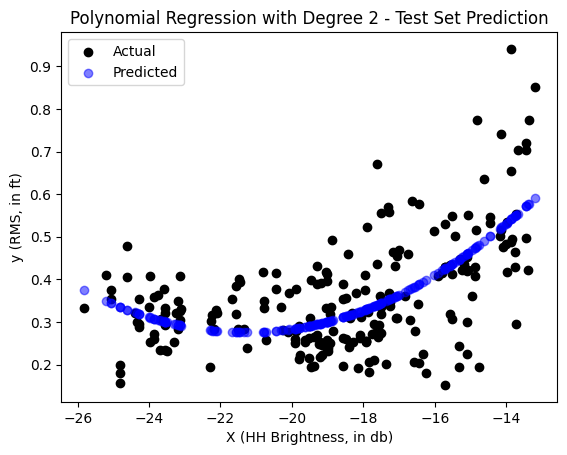

In [35]:
## Use polynomial regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

polynomial_features = PolynomialFeatures(degree=2)
X_poly_train = polynomial_features.fit_transform(X_train)

model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_train)

X_poly_test = polynomial_features.transform(X_test)

y_pred_poly = model_poly.predict(X_poly_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
print(f"The Mean Squared Error (MSE) on the test set is: {mse}")

plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, y_pred_poly, color='blue', label='Predicted', alpha=0.5)
plt.title('Polynomial Regression with Degree 2 - Test Set Prediction')
plt.xlabel('X (HH Brightness, in db)')
plt.ylabel('y (RMS, in ft)')
plt.legend()
plt.show()

In [36]:
## Save polynomial regression model

import joblib

joblib.dump(model_poly, '/content/drive/MyDrive/GEOL0069/project/polynomial_regression_model.pkl')
joblib.dump(polynomial_features, '/content/drive/MyDrive/GEOL0069/project/polynomial_features.pkl')

['/content/drive/MyDrive/GEOL0069/project/polynomial_features.pkl']

Epoch 1/20
30/30 [==============================] - 1s 3ms/step - loss: 0.0431
Epoch 2/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 3/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 4/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 5/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 6/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 7/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 8/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 9/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 10/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 11/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 12/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 13/20
30/30 [==============================

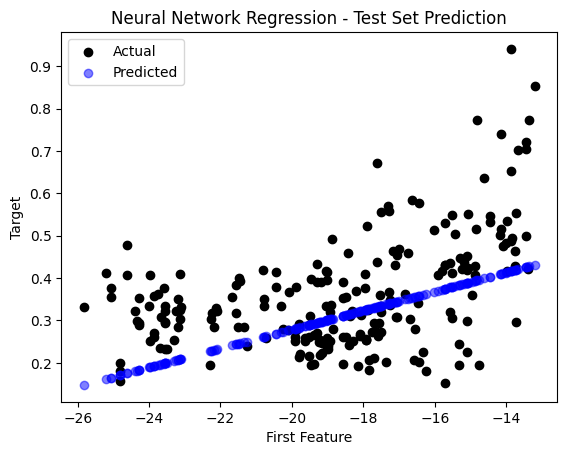

In [37]:
## Use neural network regression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(1,)),
    Dense(1)
])

model_nn.compile(optimizer='adam', loss='mean_squared_error')

model_nn.fit(X_train, y_train, epochs=20)

y_pred = model_nn.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"The Mean Squared Error (MSE) on the test set is: {mse}")

model_nn.summary()

y_pred_nn = y_pred.flatten()

plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, y_pred_nn, color='blue', label='Predicted', alpha=0.5)
plt.title('Neural Network Regression - Test Set Prediction')
plt.xlabel('First Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

In [38]:
! pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.9 MB/s eta 0:00:00


The Mean Squared Error (MSE) on the test set is: 0.12925786452457347


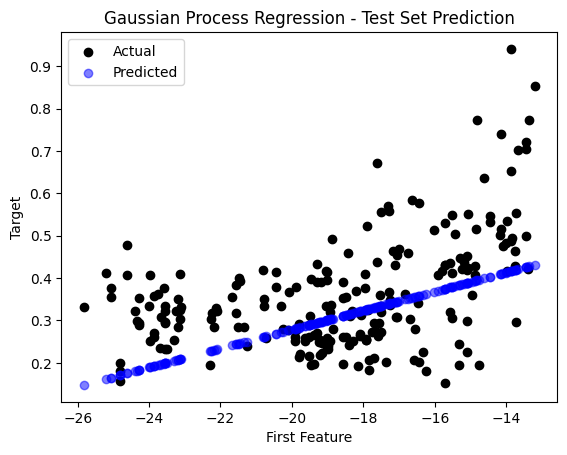

In [39]:
## Use gaussian process regression

import GPy
from sklearn.metrics import mean_squared_error

kernel = GPy.kern.RBF(input_dim=1)
num_inducing = 100

gp = GPy.models.SparseGPRegression(X_train, y_train.reshape(-1, 1), kernel, num_inducing=num_inducing)

gp.optimize(messages=True)

y_pred_gp, variance = gp.predict(X_test)
y_pred_gp = y_pred.flatten()
sigma = np.sqrt(variance).flatten()

mse = np.sqrt(mean_squared_error(y_test, y_pred_gp))
print(f"The Mean Squared Error (MSE) on the test set is: {mse}")

plt.scatter(X_test, y_test, color='black', label='Actual')
plt.scatter(X_test, y_pred_gp, color='blue', label='Predicted', alpha=0.5)
plt.title('Gaussian Process Regression - Test Set Prediction')
plt.xlabel('First Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

### Gaussian using GPSat

In [ ]:
## Prepare repository for GPSat

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

fatal: destination path 'GPSat' already exists and is not an empty directory.
changing directory to: /content/GPSat


In [ ]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment


In [ ]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GPSat


In [ ]:
## Initialise a GP model via GPSat

import numpy as np
import scipy
import matplotlib.pyplot as plt
from GPSat.models.sklearn_models import sklearnGPRModel

gpr = sklearnGPRModel(coords=X_test, obs=y_test, kernel='RBF', verbose=False)

'__init__': 0.027 seconds


In [ ]:
## Check lengthscale and kernel variance

ls = gpr.get_lengthscales()
kv = gpr.get_kernel_variance()

print(f"Lengthscale: {ls}, Kernel variance: {kv}")

Lengthscale: [1.], Kernel variance: 1.0


In [ ]:
## Set new kernel variance

gpr.set_kernel_variance(1.5)
kv = gpr.get_kernel_variance()
print(f"New kernel variance: {kv:.1f}")

New kernel variance: 1.5


In [ ]:
print(f"Likelihood variance: {gpr.get_likelihood_variance()}")

Likelihood variance: 1.0


In [ ]:
## Set new likelihood variance

alpha = 0.05
gpr.set_likelihood_variance(alpha**2)
print(f"New likelihood variance: {gpr.get_likelihood_variance():.4f}")

New likelihood variance: 0.0025


In [ ]:
## Initialise a new GP model with the desired likelihood and kernl variance values
gpr = sklearnGPRModel(coords=X_test, obs=y_test, kernel='RBF', likelihood_variance=alpha**2, kernel_variance=1.5, verbose=False)

ls = gpr.get_lengthscales()
kv = gpr.get_kernel_variance()
lv = gpr.get_likelihood_variance()

print(f"Lengthscale: {ls},  Kernel variance: {kv:.1f},  Likelihood variance: {lv:.4f}")

'__init__': 0.004 seconds
Lengthscale: [1.],  Kernel variance: 1.5,  Likelihood variance: 0.0025


'predict': 0.011 seconds


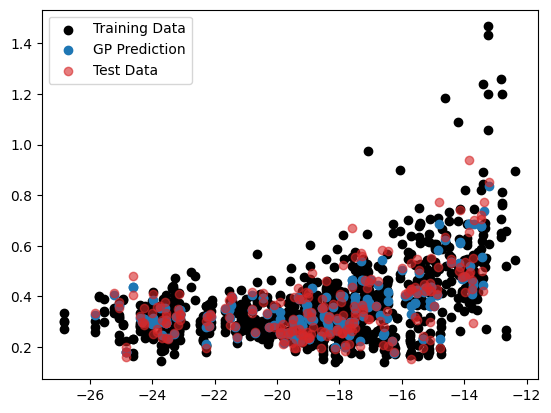

In [ ]:
# Make predictions on a uniform grid using X_test
pred_dict = gpr.predict(X_test.reshape(-1, 1))

# Extract the mean and variance from the results dictionary
f_mean = pred_dict['f*']
f_var = pred_dict['f*_var']
f_std = np.sqrt(f_var)

# Plot results
plt.scatter(X_train, y_train, color='k', zorder=0, label='Training Data')
plt.scatter(X_test, f_mean, color='C0', zorder=1, label='GP Prediction')
# plt.fill_between(X_train, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C0', alpha=0.3)
plt.scatter(X_test, y_test, color='C3', alpha=0.6, zorder=2, label='Test Data')
plt.legend()

In [ ]:
print(f"Mean squared error: {np.mean((y_test - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(y_test, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0035
Mean log likelihood: 0.4886


In [ ]:
print(f"log marginal likelihood = {gpr.get_objective_function_value():.4f}")

'get_objective_function_value': 0.000 seconds
log marginal likelihood = -13.1263


In [ ]:
## Optimise model
opt_success = gpr.optimise_parameters()

# Outputs
print(f"Optimise success: {opt_success}")
print("-"*30)
param_dict = gpr.get_parameters(*gpr.param_names)
print("Values of model hyperparameters after training:")
for k, v in param_dict.items():
    print(f"{k} : {v:.4f}")
print("-"*30)
print(f"log marginal likelihood (after training) = {gpr.get_objective_function_value():.4f}")

'optimise_parameters': 0.271 seconds
Optimise success: True
------------------------------
'get_parameters': 0.000 seconds
Values of model hyperparameters after training:
lengthscales : 0.7358
kernel_variance : 0.0142
likelihood_variance : 0.0025
------------------------------
'get_objective_function_value': 0.000 seconds
log marginal likelihood (after training) = -21.9352


'predict': 0.004 seconds


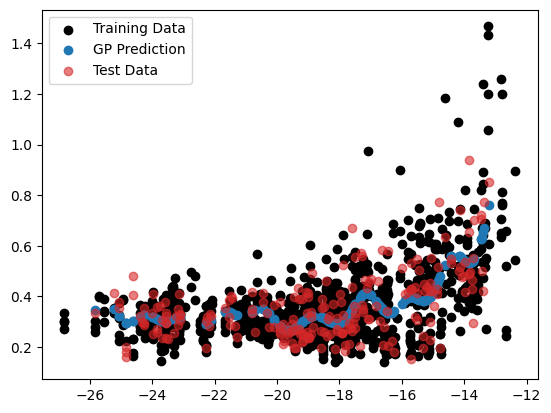

In [ ]:
## Make new predictions with optimised model
pred_dict = gpr.predict(X_test[:,None])

f_mean = pred_dict['f*']
f_var = pred_dict['f*_var']
f_std = np.sqrt(f_var)

plt.scatter(X_train, y_train, color='k', zorder=0, label='Training Data')
plt.scatter(X_test, f_mean, color='C0', zorder=1, label='GP Prediction')
# plt.fill_between(X_train, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C0', alpha=0.3)
plt.scatter(X_test, y_test, color='C3', alpha=0.6, zorder=2, label='Test Data')
plt.legend()

### Using polynomial model over Pond Inlet

In [40]:
## Reset

import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/GEOL0069/project/data/'

In [41]:
## Re-load Sentinel-1 lon, lat and brightness

lon_S1=np.load(path+'lon_S1_17N.npy')
lat_S1=np.load(path+'lat_S1_17N.npy')
brightness=np.load(path+'HH_S1_17N.npy')

In [42]:
## Remove NaN values

valid_indices = ~np.isnan(brightness)

brightness = brightness[valid_indices]
lon_S1 = lon_S1[valid_indices]
lat_S1 = lat_S1[valid_indices]

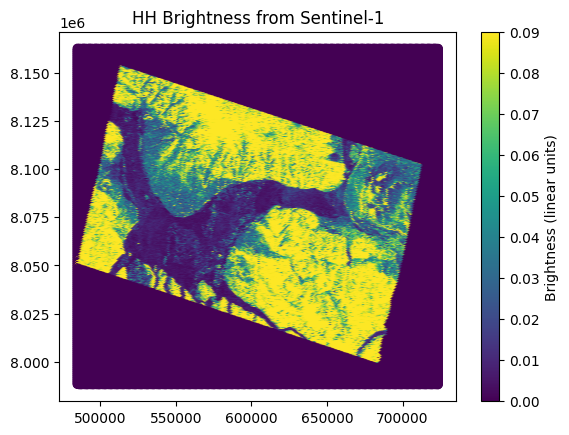

In [43]:
## Plot Sentinel-1 data

plt.scatter(lon_S1[::100],lat_S1[::100],c=brightness[::100],vmin=0,vmax=0.09)
plt.colorbar(label='Brightness (linear units)')
plt.title('HH Brightness from Sentinel-1')
plt.show()

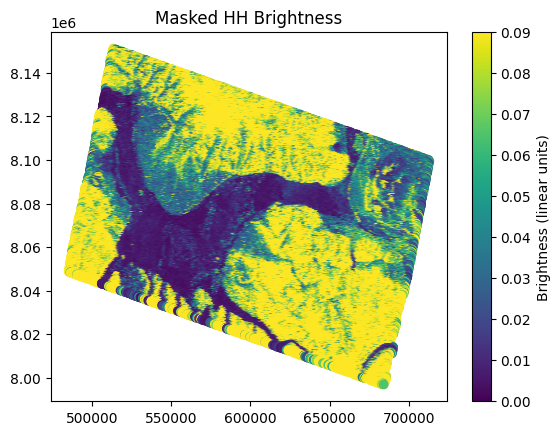

In [44]:
## Mask for 0 values

mask = brightness != 0

filtered_lon = lon_S1[mask]
filtered_lat = lat_S1[mask]
filtered_brightness = brightness[mask]

plt.scatter(filtered_lon[::100],filtered_lat[::100],c=filtered_brightness[::100],vmin=0,vmax=0.09)
plt.colorbar(label='Brightness (linear units)')
plt.title('Masked HH Brightness')
plt.show()

In [45]:
## Convert linear units to decibels

brightness[brightness <= 0] = 1e-10
db_brightness = 10 * np.log10(brightness)

In [46]:
np.min(db_brightness)

-100.0

In [47]:
## Load polynomial regression model using joblib

import joblib

model_poly = joblib.load('/content/drive/MyDrive/GEOL0069/project/polynomial_regression_model.pkl')
polynomial_features = joblib.load('/content/drive/MyDrive/GEOL0069/project/polynomial_features.pkl')

In [48]:
## Predict roughness using polynomial model

db_brightness = db_brightness.reshape(-1, 1)

X_poly_test = polynomial_features.transform(db_brightness)
y_pred_poly = model_poly.predict(X_poly_test)

In [49]:
print(lon_S1.shape,lat_S1.shape, y_pred_poly.shape)

(25996608,) (25996608,) (25996608,)


In [50]:
np.min(y_pred_poly),np.max(y_pred_poly)

(0.27574536158321594, 30.190927362844)

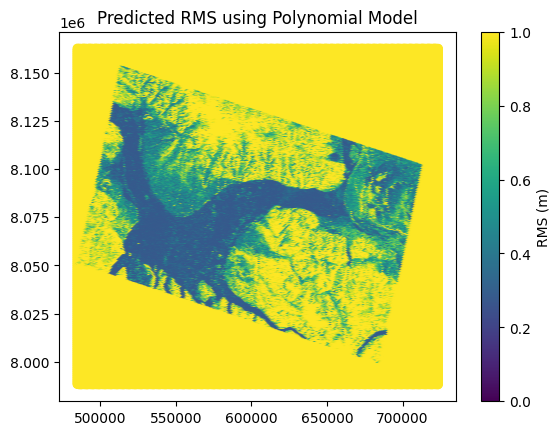

In [51]:
## Plot predicted RMS roughness using polynomial model

plt.scatter(lon_S1[::100],lat_S1[::100],c=y_pred_poly[::100],vmin=0,vmax=1)
plt.colorbar(label='RMS (m)')
plt.title('Predicted RMS using Polynomial Model')
plt.show()

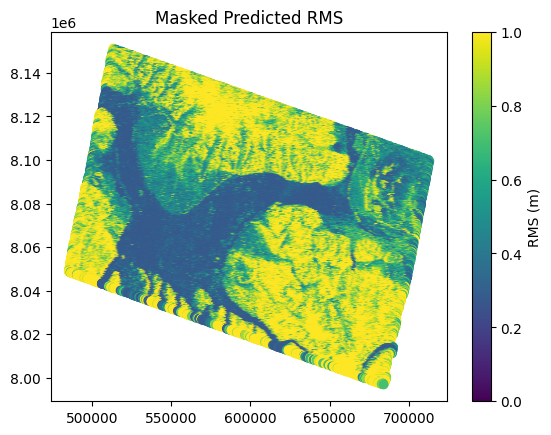

In [52]:
## Mask for predictions of 0 values

mask_pred = ~np.isclose(y_pred_poly, 30.190927362844, atol=1e-8)

filtered_lon = lon_S1[mask_pred]
filtered_lat = lat_S1[mask_pred]
filtered_y_pred_poly = y_pred_poly[mask_pred]

plt.scatter(filtered_lon[::100],filtered_lat[::100],c=filtered_y_pred_poly[::100],vmin=0,vmax=1)
plt.colorbar(label='RMS (m)')
plt.title('Masked Predicted RMS')
plt.show()

### Using polynomial model over Cambridge Bay

In [336]:
## Cambridge Bay pre-processed Sentinel-1 .tif files to .npy

tif_path = '/content/drive/MyDrive/GEOL0069/project/tif_files/subset_HH_pro_S1A_EW_GRDM_1SDH_20230419T135049_20230419T135145_048166_05CA7C_5C05_13N.tif'
x_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lon_S1_13N_CB.npy'
y_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lat_S1_13N_CB.npy'
z_output_path = '/content/drive/MyDrive/GEOL0069/project/data/HH_S1_13N_CB.npy'
export_xyz_to_npy(tif_path, x_output_path, y_output_path, z_output_path)

X (longitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/data/lon_S1_13N_CB.npy
Y (latitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/data/lat_S1_13N_CB.npy
Z (pixel brightness) values saved to /content/drive/MyDrive/GEOL0069/project/data/HH_S1_13N_CB.npy


In [53]:
## Reset

import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/GEOL0069/project/data/'

In [54]:
## Load Sentinel-1 lon, lat and brightness

lon_S1=np.load(path+'lon_S1_13N_CB.npy')
lat_S1=np.load(path+'lat_S1_13N_CB.npy')
brightness=np.load(path+'HH_S1_13N_CB.npy')

In [55]:
## Remove NaN values

valid_indices = ~np.isnan(brightness)

brightness = brightness[valid_indices]
lon_S1 = lon_S1[valid_indices]
lat_S1 = lat_S1[valid_indices]

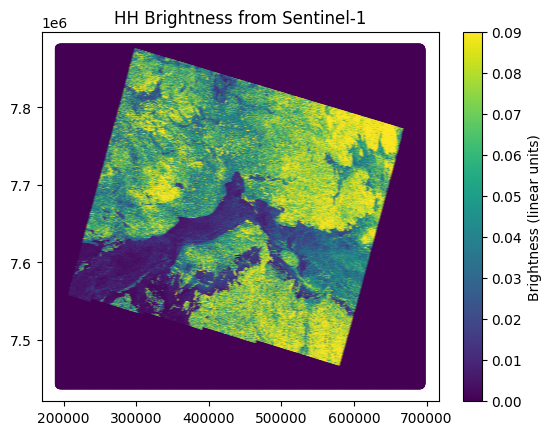

In [56]:
## Plot Sentinel-1 data

plt.scatter(lon_S1[::100],lat_S1[::100],c=brightness[::100],vmin=0,vmax=0.09)
plt.colorbar(label='Brightness (linear units)')
plt.title('HH Brightness from Sentinel-1')
plt.show()

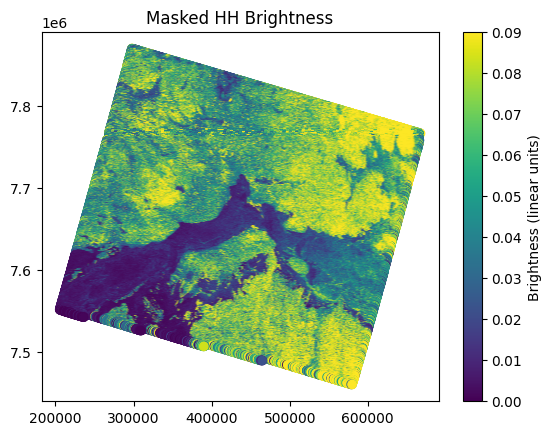

In [57]:
## Mask for 0 values

mask = brightness != 0

filtered_lon = lon_S1[mask]
filtered_lat = lat_S1[mask]
filtered_brightness = brightness[mask]

plt.scatter(filtered_lon[::100],filtered_lat[::100],c=filtered_brightness[::100],vmin=0,vmax=0.09)
plt.colorbar(label='Brightness (linear units)')
plt.title('Masked HH Brightness')
plt.show()

In [58]:
## Convert linear units to decibels

brightness[brightness <= 0] = 1e-10
db_brightness = 10 * np.log10(brightness)

In [59]:
## Load polynomial regression model using joblib

import joblib

model_poly = joblib.load('/content/drive/MyDrive/GEOL0069/project/polynomial_regression_model.pkl')
polynomial_features = joblib.load('/content/drive/MyDrive/GEOL0069/project/polynomial_features.pkl')

In [60]:
## Predict roughness using polynomial model

db_brightness = db_brightness.reshape(-1, 1)

X_poly_test = polynomial_features.transform(db_brightness)
y_pred_poly = model_poly.predict(X_poly_test)

In [61]:
print(lon_S1.shape,lat_S1.shape, y_pred_poly.shape)

(134663736,) (134663736,) (134663736,)


In [62]:
np.min(y_pred_poly),np.max(y_pred_poly)

(0.27574536141511263, 30.190927362844)

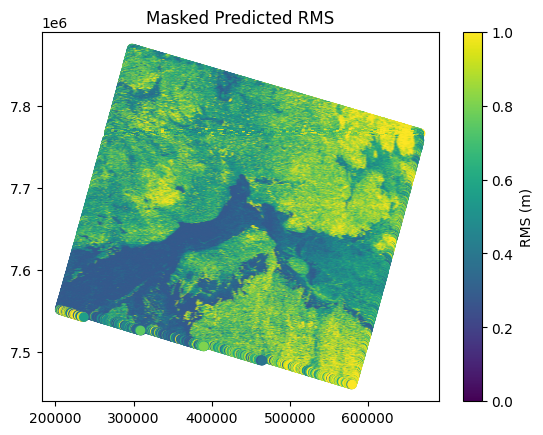

In [63]:
## Mask for predictions of 0 values

mask_pred = ~np.isclose(y_pred_poly, 30.190927362844, atol=1e-8)

filtered_lon = lon_S1[mask_pred]
filtered_lat = lat_S1[mask_pred]
filtered_y_pred_poly = y_pred_poly[mask_pred]

plt.scatter(filtered_lon[::100],filtered_lat[::100],c=filtered_y_pred_poly[::100],vmin=0,vmax=1)
plt.colorbar(label='RMS (m)')
plt.title('Masked Predicted RMS')
plt.show()

### Using polynomial model over Arctic Bay

In [319]:
## Arctic Bay pre-processed Sentinel-1 .tif files to .npy

tif_path = '/content/drive/MyDrive/GEOL0069/project/tif_files/subset_HH_pro_S1A_EW_GRDM_1SDH_20230420T125214_20230420T125314_048180_05CAF1_BDD4_16N.tif'
x_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lon_S1_16N_AB.npy'
y_output_path = '/content/drive/MyDrive/GEOL0069/project/data/lat_S1_16N_AB.npy'
z_output_path = '/content/drive/MyDrive/GEOL0069/project/data/HH_S1_16N_AB.npy'
export_xyz_to_npy(tif_path, x_output_path, y_output_path, z_output_path)

X (longitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/data/lon_S1_16N_AB.npy
Y (latitude) coordinates saved to /content/drive/MyDrive/GEOL0069/project/data/lat_S1_16N_AB.npy
Z (pixel brightness) values saved to /content/drive/MyDrive/GEOL0069/project/data/HH_S1_16N_AB.npy


In [64]:
## Reset

import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/GEOL0069/project/data/'

In [65]:
## Load Sentinel-1 lon, lat and brightness

lon_S1=np.load(path+'lon_S1_16N_AB.npy')
lat_S1=np.load(path+'lat_S1_16N_AB.npy')
brightness=np.load(path+'HH_S1_16N_AB.npy')

In [66]:
## Remove NaN values

valid_indices = ~np.isnan(brightness)

brightness = brightness[valid_indices]
lon_S1 = lon_S1[valid_indices]
lat_S1 = lat_S1[valid_indices]

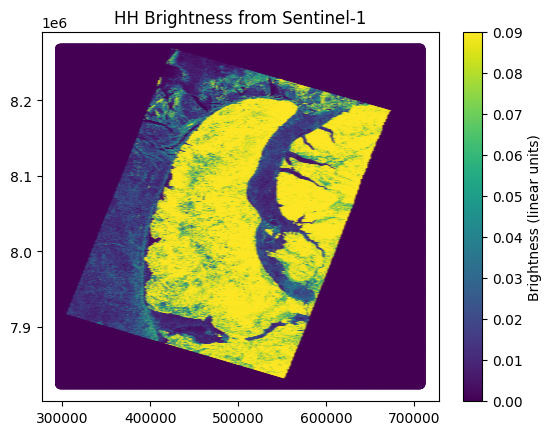

In [67]:
## Plot Sentinel-1 data

plt.scatter(lon_S1[::100],lat_S1[::100],c=brightness[::100],vmin=0,vmax=0.09)
plt.colorbar(label='Brightness (linear units)')
plt.title('HH Brightness from Sentinel-1')
plt.show()

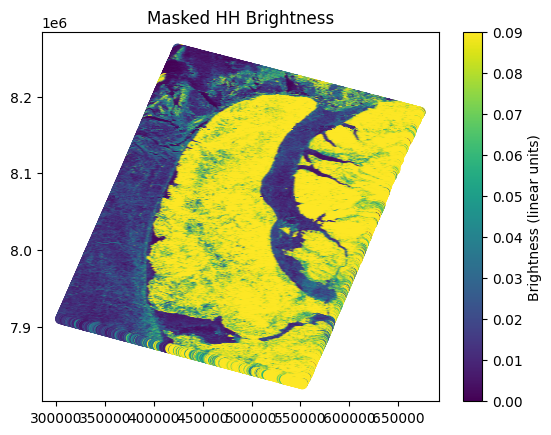

In [68]:
## Mask for 0 values

mask = brightness != 0

filtered_lon = lon_S1[mask]
filtered_lat = lat_S1[mask]
filtered_brightness = brightness[mask]

plt.scatter(filtered_lon[::100],filtered_lat[::100],c=filtered_brightness[::100],vmin=0,vmax=0.09)
plt.colorbar(label='Brightness (linear units)')
plt.title('Masked HH Brightness')
plt.show()

In [69]:
## Convert linear units to decibels

brightness[brightness <= 0] = 1e-10
db_brightness = 10 * np.log10(brightness)

In [70]:
## Load polynomial regression model using joblib

import joblib

model_poly = joblib.load('/content/drive/MyDrive/GEOL0069/project/polynomial_regression_model.pkl')
polynomial_features = joblib.load('/content/drive/MyDrive/GEOL0069/project/polynomial_features.pkl')

In [71]:
## Predict roughness using polynomial model

db_brightness = db_brightness.reshape(-1, 1)

X_poly_test = polynomial_features.transform(db_brightness)
y_pred_poly = model_poly.predict(X_poly_test)

In [72]:
print(lon_S1.shape,lat_S1.shape, y_pred_poly.shape)

(114105637,) (114105637,) (114105637,)


In [73]:
np.min(y_pred_poly),np.max(y_pred_poly)

(0.27574536141511263, 30.190927362844)

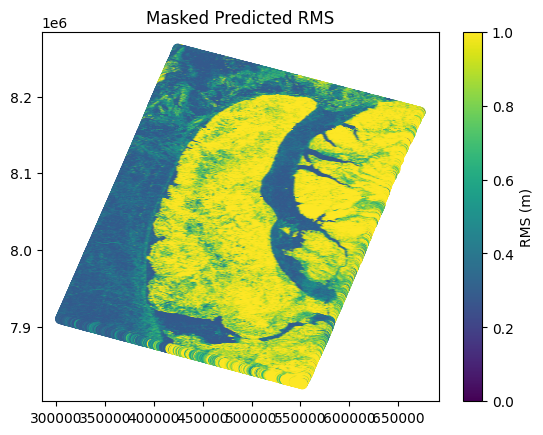

In [74]:
## Mask for predictions of 0 values

mask_pred = ~np.isclose(y_pred_poly, 30.190927362844, atol=1e-8)

filtered_lon = lon_S1[mask_pred]
filtered_lat = lat_S1[mask_pred]
filtered_y_pred_poly = y_pred_poly[mask_pred]

plt.scatter(filtered_lon[::100],filtered_lat[::100],c=filtered_y_pred_poly[::100],vmin=0,vmax=1)
plt.colorbar(label='RMS (m)')
plt.title('Masked Predicted RMS')
plt.show()

### Sensitivity Analysis

In [75]:
## Split (256,6) form of combined arrays into testing and training data

import numpy as np
from sklearn.model_selection import train_test_split

path = '/content/drive/MyDrive/GEOL0069/project/data/'

features_path = path + 'array_20_combined_db_DEM.npy'
targets_path = path + 'array_20_combined_rms_DEM.npy'

input_features = np.load(features_path)
target_variables = np.load(targets_path)

X_train, X_test, y_train, y_test = train_test_split(input_features, target_variables, test_size=0.2, random_state=50)

In [76]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(204, 6) (204, 6) (52, 6) (52, 6)


In [77]:
## Remove NaN values
# training data
train_valid_indices = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train).any(axis=1)
X_train = X_train[train_valid_indices]
y_train = y_train[train_valid_indices]

# test data
test_valid_indices = ~np.isnan(X_test).any(axis=1) & ~np.isnan(y_test).any(axis=1)
X_test = X_test[test_valid_indices]
y_test = y_test[test_valid_indices]

In [78]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(92, 6) (92, 6) (20, 6) (20, 6)


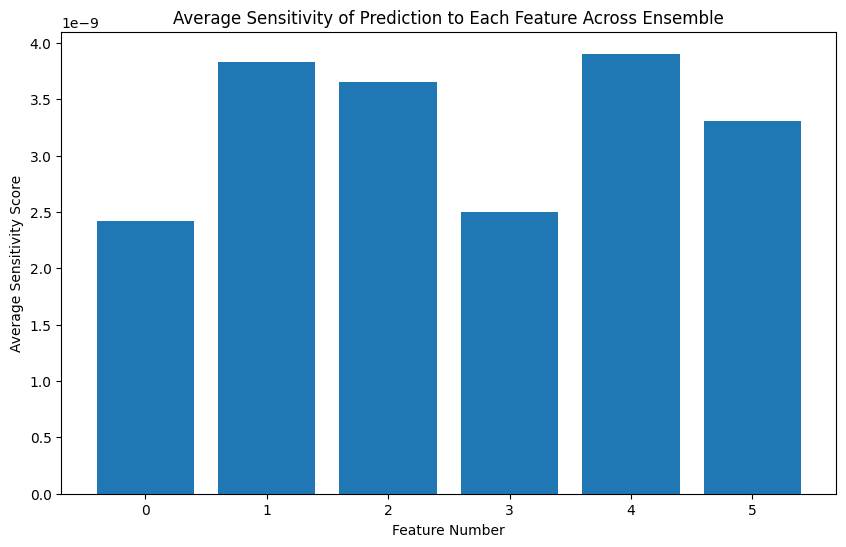

In [79]:
## Average sensitivity score calculation for the 6 DEM grids

import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import layers, models, Sequential
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(10)
tf.random.set_seed(10)
random.seed(10)

# Define the CNN model architecture as a function for reusability
def create_model(input_shape):
    model = Sequential([
        layers.Dense(256, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='softplus') # Suitable for positive output values (Keras def.: softplus(x) = log(exp(x) + 1))
    ])
    return model

# Sensitivity analysis function
def sensitivity_analysis(model, input_data, class_idx):
    input_data_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_data_tensor)
        predictions = model(input_data_tensor, training=False)
        class_output = predictions[:, class_idx]

    gradients = tape.gradient(class_output, input_data_tensor)
    feature_sensitivity = tf.reduce_sum(tf.abs(gradients), axis=0)
    return feature_sensitivity.numpy()

# Ensemble approach: Train multiple models and compute average sensitivity
num_models = 5  # Number of models in the ensemble
ensemble_sensitivities = []

for i in range(num_models):
    # Create and compile a new model instance
    model = create_model((X_train.shape[1],))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)  # Set verbose to 0 to reduce log output

    # Perform sensitivity analysis on a sample image for each model
    sample_data = X_test[:1]  # Use the first sample in X_test
    class_idx = 0  # For regression, we use 0 since it's a single output

    feature_sensitivity = sensitivity_analysis(model, sample_data, class_idx)
    ensemble_sensitivities.append(feature_sensitivity)

# Average the sensitivity scores across all models
average_sensitivity = np.mean(ensemble_sensitivities, axis=0)

# Visualize the average sensitivity scores
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), average_sensitivity)
plt.xlabel('Feature Number')
plt.ylabel('Average Sensitivity Score')
plt.title('Average Sensitivity of Prediction to Each Feature Across Ensemble')
plt.show()